In [35]:
%matplotlib inline
# color-blind friendly colors
red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
gray = '#999999'
yellow = '#dede00'
colors = [red, blue, green, pink, brown, purple, gray, yellow]

In [1]:
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import SubhaloPhaseSpace

logmmin, logmmax = 10.6, 15.2
subocc_model = SubhaloPhaseSpace('satellites', np.logspace(logmmin, logmmax, 15))

baseline_model = PrebuiltHodModelFactory('cacciato09')
model = HodModelFactory(baseline_model_instance=baseline_model, 
                       satellites_profile=subocc_model)

model.populate_mock(CachedHaloCatalog(simname='bolplanck'))

In [29]:
model.mock.populate()

In [51]:
gals = model.mock.galaxy_table

low_mhost, high_mhost = 10**13.9, 10**14.1
mhost_mask = (gals['halo_mvir_host_halo'] > low_mhost) & (gals['halo_mvir_host_halo'] < high_mhost)
sample = gals[mhost_mask]

satmask = sample['gal_type'] == 'satellites'
sats = sample[satmask]
cens = sample[~satmask]

print("Number of satellites = {0}".format(len(sats)))
print("Number of centrals = {0}".format(len(cens)))

Number of satellites = 2322
Number of centrals = 309


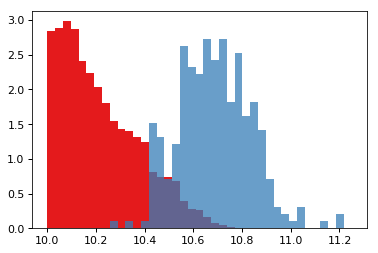

In [38]:
fig, ax = plt.subplots(1, 1)

num_lumbins = 40
__=ax.hist(np.log10(sats['luminosity']), 
           bins=np.linspace(model.threshold, 11.25, num_lumbins), normed=True, 
          color=red)
__=ax.hist(np.log10(cens['luminosity']), 
           bins=np.linspace(model.threshold, 11.25, num_lumbins), normed=True, 
           alpha=0.75, color=blue)

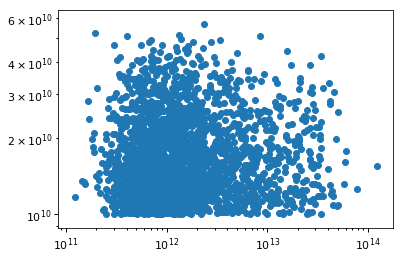

In [41]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()
__=ax.scatter(sats['halo_mpeak'], sats['luminosity'])

In [49]:
from halotools.empirical_models import conditional_abunmatch

new_luminosity = conditional_abunmatch(sats['halo_mpeak'], sats['luminosity'], sigma=0)
new_luminosity2 = conditional_abunmatch(sats['halo_mpeak'], sats['luminosity'], sigma=0.1)


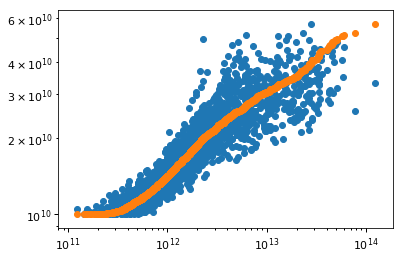

In [48]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()
__=ax.scatter(sats['halo_mpeak'], new_luminosity2)
__=ax.scatter(sats['halo_mpeak'], new_luminosity)


In [87]:
from halotools.empirical_models import conditional_abunmatch

new_luminosity = conditional_abunmatch(sats['halo_mpeak'], sats['luminosity'], sigma=0)

def new_galprop(gals, sigma, dlogm=0.25, mhost_bins=None, 
                     binning_key='halo_mvir_host_halo', 
                    correlated_haloprop_key='halo_mpeak', 
                     correlated_galprop_key='luminosity', 
                    new_colname='new_luminosity'):
    
    result = np.copy(gals[correlated_galprop_key].data)
    
    if mhost_bins is None:
        low_mhost, high_mhost = gals[binning_key].min(), gals[binning_key].max() 
        log_low_mhost, log_high_mhost = np.log10(low_mhost)-0.01, np.log10(high_mhost)+0.01
        nbins = int((log_high_mhost - log_low_mhost)/float(dlogm))
        mhost_bins = np.logspace(log_low_mhost, log_high_mhost, nbins)
    else:
        nbins = len(mhost_bins)
    
    for ibin in range(nbins):
        mhost_mask = gals[binning_key] > low_mhost
        mhost_mask *= gals[binning_key] < high_mhost        
        satmask = mhost_mask*(gals['gal_type'] == 'satellites')
        sample = gals[satmask]
        sample_galprop = np.log10(sample[correlated_galprop_key])
        sample_haloprop = np.log10(sample[correlated_haloprop_key])
        result[satmask] = 10**conditional_abunmatch(sample_galprop, sample_haloprop, sigma=sigma)

    return result

In [88]:
model.mock.populate()
gals = model.mock.galaxy_table
gals['new_luminosity'] = new_galprop(gals, 0.1)

In [95]:
mask = gals['new_luminosity'] == gals['luminosity']
set(gals['gal_type'][mask])

sats = gals[gals['gal_type'] == 'satellites']
cens = gals[gals['gal_type'] == 'centrals']

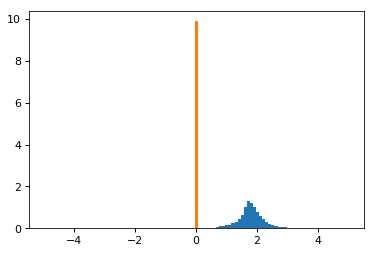

In [97]:
fig, ax = plt.subplots(1, 1)

logdiff = np.log10(sats['new_luminosity']) - np.log10(sats['luminosity'])
logdiff_cens = np.log10(cens['new_luminosity']) - np.log10(cens['luminosity'])

__=ax.hist(logdiff, bins=np.linspace(-5, 5, 100), normed=True)
__=ax.hist(logdiff_cens, bins=np.linspace(-5, 5, 100), normed=True)

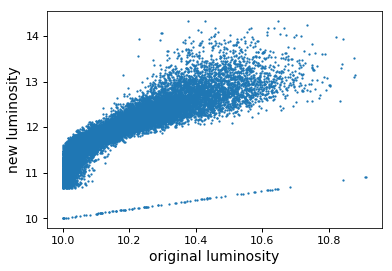

In [104]:
fig, ax = plt.subplots(1, 1)

__=ax.scatter(np.log10(sats['luminosity']), np.log10(sats['new_luminosity']), s=1.5)

xlabel = ax.set_xlabel('original luminosity', size=14)
ylabel = ax.set_ylabel('new luminosity', size=14)


In [106]:
np.log10(sats['new_luminosity'].max())

14.330210801008821